# 2022-02-07 • Big-N-to-1 simulation

## Setup

In [187]:
# Pkg.resolve()

In [188]:
include("nb_init.jl")

[ Info: using Revise
[ Info: import Distributions
[ Info: import PyPlot
[ Info: import DataFrames, PrettyTables
[ Info: import MyToolbox, Sciplotlib
[ Info: using VoltageToMap


In [189]:
using Parameters, ComponentArrays
@alias CVec = ComponentVector;

## Parameters

### Simulation duration

In [190]:
sim_duration = 1.2 * seconds;

### Input spike trains

In [191]:
N_unconn = 100
N_exc    = 800
# N_exc    = 5200
N_inh    = N_exc ÷ 4

200

In [192]:
N_conn = N_inh + N_exc

1000

In [193]:
N = N_conn + N_unconn

1100

In [194]:
input_spike_rate = LogNormal_with_mean(4Hz, √0.6)  # See the previous notebook

LogNormal{Float64}(μ=1.0862943611198905, σ=0.7745966692414834)

### Synapses

Reversal potential at excitatory and inhibitory synapses,
as in the report [`2021-11-11__synaptic_conductance_ratio.pdf`](https://github.com/tfiers/phd-thesis/blob/main/reports/2021-11-11__synaptic_conductance_ratio.pdf):

In [195]:
E_exc =   0 * mV
E_inh = -65 * mV;

Synaptic conductances `g` at `t = 0`

In [196]:
g_t0 = 0 * nS;

Exponential decay time constant of synaptic conductance, $τ_{s}$ (`s` for "synaptic")

In [197]:
τ_s = 7 * ms;

Increase in synaptic conductance on a presynaptic spike

In [198]:
Δg_exc = 0.1 * nS
Δg_inh = 0.4 * nS;

### Izhikevich neuron

Initial membrane potential `v` and adaptation variable `u` values

In [199]:
v_t0  = -80 * mV
u_t0  =   0 * pA;

Izhikevich's neuron model parameters for a cortical regular spiking neuron:

In [200]:
cortical_RS = CVec(
    C      = 100 * pF,
    k      = 0.7 * (nS/mV),  # steepness of dv/dt's parabola
    vr     = -60 * mV,
    vt     = -40 * mV,
    a      = 0.03 / ms,      # 1 / time constant of `u`
    b      = -2 * nS,        # how strongly `v` deviations from `vr` increase `u`.
    v_peak =  35 * mV,
    c      = -50 * mV,       # reset voltage.
    d      = 100 * pA,       # `u` increase on spike. Free parameter.
);

### Numerics

Whether to use a fixed (`false`) or [adaptive](https://www.wikiwand.com/en/Adaptive_step_size) timestep (`true`).

In [201]:
adaptive = true;

Timestep. If `adaptive`, size of first time step.

In [202]:
dt = 0.1 * ms;

Error tolerances used for determining step size, if `adaptive`.

The solver guarantees that the (estimated) difference between
the numerical solution and the true solution at any time step
is not larger than `abstol + reltol * |y|`
(where `y` ≈ the numerical solution at that time step).

In [203]:
abstol_v = 0.1 * mV
abstol_u = 0.1 * pA
abstol_g = 0.01 * nS;

In [204]:
reltol = 1e-3;  # e.g. if true sol is -80 mV, then max error of 0.08 mV
reltol = 1;     # only use abstol

From the manual: "These tolerances are local tolerances and thus are not global guarantees. However, a good rule of thumb is that the total solution accuracy is 1-2 digits less than the relative tolerances." [[1]](https://diffeq.sciml.ai/stable/basics/faq/#What-does-tolerance-mean-and-how-much-error-should-I-expect)

In [205]:
tol_correction = 0.1;

In [206]:
(abstol_v, abstol_u, abstol_g) .* tol_correction

(1.0e-5, 1.0000000000000002e-14, 1.0000000000000002e-12)

For comparison, the default tolerances for ODEs in DifferentialEquations.jl are
- `reltol = 1e-2`
- `abstol = 1e-6`.

## IDs

Neuron, synapse & simulated variable IDs.

IDs and connections are simple here for the N-to-1 case: only input 'neurons' get an ID, and there is only one synapse for every (connected) neuron.

A utility function. See below for its usage.

In [207]:
"""
    idvec(A = 4, B = 2, …)

Build a `ComponentVector` (CVec) with the given group names and
as many elements per group as specified. Each element gets a
unique ID within the CVec, which is also its index in the CVec.
I.e. the above call yields `CVec(A = [1,2,3,4], B = [5,6])`.
"""
function idvec(; kw...)
    cvec = CVec(; (name => _expand(val) for (name, val) in kw)...)
    cvec .= 1:length(cvec)
    return cvec
end;

temp = -1  # value does not matter; they get overwritten by UnitRange
_expand(val::Nothing) = temp
_expand(val::Integer) = fill(temp, val)
_expand(val::CVec)    = val              # allow nested idvecs
;

In [208]:
neurons = idvec(conn = idvec(exc = N_exc, inh = N_inh), unconn = N_unconn)

ComponentVector{Int64}(conn = (exc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  791, 792, 793, 794, 795, 796, 797, 798, 799, 800], inh = [801, 802, 803, 804, 805, 806, 807, 808, 809, 810  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]), unconn = [1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010  …  1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100])

In [209]:
synapses = idvec(exc = N_exc, inh = N_inh)

ComponentVector{Int64}(exc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  791, 792, 793, 794, 795, 796, 797, 798, 799, 800], inh = [801, 802, 803, 804, 805, 806, 807, 808, 809, 810  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000])

In [210]:
simulated_vars = idvec(v = nothing, u = nothing, g = synapses)

ComponentVector{Int64}(v = 1, u = 2, g = (exc = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12  …  793, 794, 795, 796, 797, 798, 799, 800, 801, 802], inh = [803, 804, 805, 806, 807, 808, 809, 810, 811, 812  …  993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002]))

Example usage of these objects:

Pick some global neuron ID

In [211]:
neuron_ID = N_exc + 2

802

We can index globally, or locally: we want the second inhibitory neuron

In [212]:
neurons[neuron_ID], neurons.conn.inh[2]

(802, 802)

Some introspection, useful for printing & plotting:

In [213]:
labels(neurons)[neuron_ID]

"conn.inh[2]"

## Connections

In [214]:
postsynapses = Dict{Int, Vector{Int}}()  # neuron_ID => [synapse_IDs...]

for (n, s) in zip(neurons.conn, synapses)
    postsynapses[n] = [s]
end
for n in neurons.unconn
    postsynapses[n] = []
end

## Broadcast parameters

A bunch of synaptic parameters are given as scalars, but pertain to multiple synapses at once.
Here we broadcast these scalars to vectors

In [215]:
Δg = similar(synapses, Float64)
Δg.exc .= Δg_exc
Δg.inh .= Δg_inh;

In [216]:
E = similar(synapses, Float64)
E.exc .= E_exc
E.inh .= E_inh;

Initial conditions:

In [217]:
vars_t0 = similar(simulated_vars, Float64)
vars_t0.v = v_t0
vars_t0.u = u_t0
vars_t0.g .= g_t0;

In [219]:
abstol = similar(simulated_vars, Float64)
abstol.v = abstol_v
abstol.u = abstol_u
abstol.g .= abstol_g
abstol = abstol .* tol_correction;

## Input spikes

Generate firing rates $λ$ by sampling from the input spike rate distribution.

In [158]:
λ = rand(input_spike_rate, N)
showsome(λ)

1100-element Vector{Float64}:
    1: 2.722664475855939
    2: 1.0009257276518295
    ⋮
  346: 3.845965311791171
    ⋮
  351: 4.684073919660121
    ⋮
 1099: 1.031039738130064
 1100: 1.755517206279862


`Distributions.jl` uses an alternative `Exp` parametrization, namely scale $β$ = 1 / rate.

In [159]:
β = 1 ./ λ
ISI_distributions = Exponential.(β);
#   This uses julia's broadcasting `.` syntax: make an `Exponential` distribution for every value in the β vector

Generate the first spike time for every input neuron by sampling once from its ISI distribution.

In [160]:
first_spike_times = rand.(ISI_distributions);

Sort these initial spike times by building a priority queue.

In [161]:
upcoming_input_spikes = PriorityQueue{Int, Float64}()

for (neuron, first_spike_time) in enumerate(first_spike_times)
    enqueue!(upcoming_input_spikes, neuron => first_spike_time)
end

Check the top of the heap to find the first spiker.

In [162]:
_, next_input_spike_time = peek(upcoming_input_spikes)
    # We `peek`, and not `dequeue_pair!`, to make this cell idempotent.

857 => 0.00026416095448424863

## Differential equations

In [163]:
params = CVec(; E, τ_s, izh = cortical_RS, next_input_spike_time);

The derivative functions that defines the differential equations.

Discontinuities are defined further down, under "Events".

In [168]:
function f(D, vars, params, _)
    @unpack v, u, g = vars
    @unpack izh, E, τ_s = params
    @unpack C, k, vr, vt, a, b = izh
    I_s = 0.0
    for (gi, Ei) in zip(g, E)
        I_s += gi * (v - Ei)
    end
    D.v = (k * (v - vr) * (v - vt) - u - I_s) / C
    D.u = a * (b * (v - vr) - u)
    D.g .= .-g ./ τ_s
    return nothing
end;

Applied performance optimizations:
- No `I_s = sum(g .* (v .- E))`, which allocates a new array. Rather: an accumulating loop.
- `D.g .= …`: elementwise assignment (instead of overwriting `D.g` with a new array that needs to be allocated).
- Parameters via function argument, and not closure global variables: to speed up type inference (apparently).

For the synaptic currents $I_{s,i}$:
membrane current is by convention positive
if positive charges are flowing _out_ of the cell.

For *e.g.* `v` = $-80$ mV and `Ei` = $0$ mV (an excitatory synapse),
we get negative $I_s$, i.e. positive charges flowing in ✔.

## Events

In [169]:
events = (
    thr_crossing           = 1,
    input_spike_generated  = 2,
)

function update_distance_to_next_event(distance, vars, t, integrator)
    v = vars.v
    p = integrator.p  # params
    distance[events.thr_crossing]          = v - p.izh.v_peak
    distance[events.input_spike_generated] = t - p.next_input_spike_time
end

function on_event(integrator, event)
    vars = integrator.u
    @unpack p, t = integrator  # params, time

    if event == events.thr_crossing
        # The discontinuous LIF/Izhikevich/AdEx update
        vars.v = p.izh.c
        vars.u += p.izh.d

    elseif event == events.input_spike_generated
        # Process the neuron that just fired. Start by removing it from the queue.
        fired_neuron = dequeue!(upcoming_input_spikes)
        # Generate a new spike time, and add it to the queue.
        new_spike_time = t + rand(ISI_distributions[fired_neuron])
        enqueue!(upcoming_input_spikes, fired_neuron => new_spike_time)
        # Update the downstream synapses (one or zero in the N-to-1 case).
        # Also note: no tx delay.
        for syn in postsynapses[fired_neuron]
            vars.g[syn] += Δg[syn]
        end
        # Update params: retrieve the next earliest spike.
        _, p.next_input_spike_time = peek(upcoming_input_spikes)
    end
end;

## diffeq.jl API

Set-up problem and solution in DifferentialEquations.jl's API.

In [170]:
@time using OrdinaryDiffEq

  0.001499 seconds (347 allocations: 22.359 KiB)


In [171]:
prob = ODEProblem(f, vars_t0, float(sim_duration), params)
    # Duration must be float too, so that `t` variable is float.

ODEProblem with uType ComponentVector{Float64, Vector{Float64}, Tuple{Axis{(v = 1, u = 2, g = ViewAxis(3:1002, Axis(exc = 1:800, inh = 801:1000)))}}} and tType Float64. In-place: true
timespan: (0.0, 1.2)
u0: ComponentVector{Float64}(v = 9.079103666e-315, u = 0.0, g = (exc = [9.0791024e-315, 0.0, 9.0791024e-315, 0.0, 9.079103666e-315, 0.0, 9.079103666e-315, 0.0, 9.0791024e-315, 0.0  …  9.079087856e-315, 0.0, 9.079087856e-315, 0.0, 9.079087856e-315, 0.0, 9.079103666e-315, 0.0, 9.079103666e-315, 0.0], inh = [9.079103666e-315, 0.0, 9.079102717e-315, 0.0, 9.079103666e-315, 0.0, 1.0000000000000002e-12, 1.0000000000000002e-12, 1.0000000000000002e-12, 1.0000000000000002e-12  …  1.0000000000000002e-12, 1.0000000000000002e-12, 1.0000000000000002e-12, 1.0000000000000002e-12, 1.0000000000000002e-12, 1.0000000000000002e-12, 1.0000000000000002e-12, 1.0000000000000002e-12, 1.0000000000000002e-12, 1.0000000000000002e-12]))

In [172]:
callback = VectorContinuousCallback(update_distance_to_next_event, on_event, length(events));

The default and recommended solver. A Runge-Kutta method. Refers to Tsitouras 2011.
See http://www.peterstone.name/Maplepgs/Maple/nmthds/RKcoeff/Runge_Kutta_schemes/RK5/RKcoeff5n_1.pdf

In [173]:
solver = Tsit5()

Tsit5(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))

Don't save all the synaptic conductances, only save `v`.

In [174]:
save_idxs = [simulated_vars.v];

In [175]:
solve_() = solve(prob, solver; dt, adaptive, abstol, reltol, callback);

## Solve

In [176]:
sol = @time solve_();

 29.521531 seconds (14.94 M allocations: 1.390 GiB, 2.46% gc time, 40.00% compilation time)


In [ ]:
using ProfileView
@profview @time solve();

In [179]:
@time import PyPlot
using Sciplotlib

  0.001061 seconds (347 allocations: 22.359 KiB)


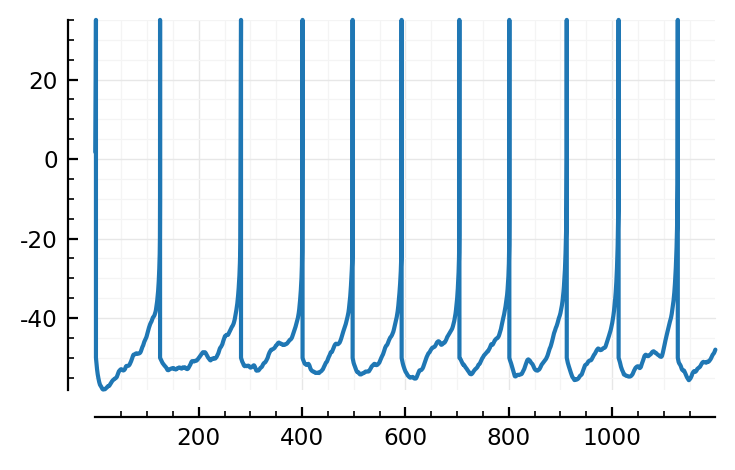

In [180]:
tzoom = sol.t[[1,end]]
# tzoom = [200ms, 600ms]
zoom = first(tzoom) .< sol.t .< last(tzoom)
Sciplotlib.plot(sol.t[zoom]/ms, sol[1,zoom]/mV, clip_on=false);